<a href="https://colab.research.google.com/github/arthursl12/MIR/blob/master/Lab10/Lab05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# Descomente e rode para usar no colab
! pip install git+https://github.com/flaviovdf/musica.git

# Decomposição de Matrizes Musicais

**Objetivos**
1. Revisar Decomposição de Matrizes
1. Revisar SVD
1. Aprender um pouco sobre NMF

**Resultado Esperado**
1. Saber fazer uso do SKLearn para separar instrumentos

In [2]:
from μsica import μsf
from μsica import μsp

from numba import jit

import jax.numpy as jnp
import jax

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [3]:
μsp.init_matplotlib()
plt.ion()

In [4]:
μsf.download('https://dcc.ufmg.br/~flaviovdf/mir/lab08/IDMT-SMT-DRUMS-V2.zip',
             'files.zip', False)
μsf.extract('files.zip', '.')

files.zip: 273MB [00:16, 9.31MB/s] 

## Introdução

Como vimos em sala de aula, a tarefa de separação de fontes (*source separation*) serve para extrair diferentes padrões de aúdio que se repetem em uma música. Aqui, um padrão pode ser visto como informação redundante na matriz do espectrograma de tempo curto. Como tal padrão se repete, a separação de fontes visa capturar os diferentes instrumentos tocados na música.

## Decomposição em Valores Singulares

Em álgebra linear, a decomposição em valores singulares ou singular value decomposition (SVD) é a fatoração de uma matriz real ou complexa, com diversas aplicações importantes em processamento de sinais e estatística.

Formalmente, a decomposição em valores singulares de uma matriz m×n real ou complexa X é uma fatoração ou fatorização na forma: 

$$ X = U \Sigma V^{*} $$ 

Aqui, $U$ é a matriz de vetores singulares à direita. $\Sigma$ é uma matriz diagonal com os valores singulares. Por fim, $V^{*}$ é a transposta conjugada dos valores singulares à direita. *Possivelmente você deve estar pensando: "massa, um monte de termo que sei muito pouco sobre"*. Se este é o seu caso, não se preocupe! Vamos tentar focar em uma ideia mais simples, que faria um matemático chorar, para explicar SVD.

Para tal, uma outra forma de escrever tal equação é:

$$ X = U_s V^{t} $$ 

onde, $U_s = U \Sigma$, ou seja, o produto da primeira parte da equação acima. Aqui, $V^{t}$ é simplesmente transposta de $V$. Não vamos nos preocupar com transpostas conjugadas pois vamos trabalhar com números reais.

Em sua forma correta, $ X = U \Sigma V^{*} $, SVD consegue decompor qualquer matriz, $X$, real ou complexa. A decomposição também vai ser complexa, isto é, $U$, $\Sigma$ e $V$ podem conter números complexos. É importante ressaltar este fato para deixar claro que SVD consegue trabalhar no espectrograma complexo caso seja necessário. Fazemos uso da versão modificada aqui, pois conseguimos visualizar o espectro usando a norma dos números complexos, ou seja, um valor real.

### Como entender SVD melhor?

*Começando com vetores*

Vamos voltar para a nossa simplificação acima: $ X = U_s V^{t} $. Agora, vamos definir $U_s$ como um vetor coluna, i.e.,:

\begin{align}
    U_s &= \begin{bmatrix}
           c_{1} \\
           c_{2} \\
           \vdots \\
           c_{n}
         \end{bmatrix}
  \end{align}

Além do mais, vamos também definir $V$ como um outro vetor coluna. Como trabalhamos com $V^t$, teremos a transposta, ou seja, um vetor linha na nossa expressão de SVD. Segue a forma de $V^t$.

\begin{align}
    V^t &= \begin{bmatrix}
           l_{1}, 
           l_{2}, 
           \cdots,
           l_{m}
         \end{bmatrix}
  \end{align}

A nossa expressão então vira:

\begin{align}
    X &= \begin{bmatrix}
           c_{1} \\
           c_{2} \\
           \vdots \\
           c_{n}
         \end{bmatrix}\begin{bmatrix}
           l_{1}, 
           l_{2}, 
           \cdots,
           l_{m}
         \end{bmatrix}
  \end{align}


Observe como o produto de um vetor coluna de tamanho $(n, 1)$ com um outro linha de tamanho $(1, m)$ gera uma matriz de tamanho $(n, m)$. Agora, uma coisa importante deste produto é que o mesmo tem *posto* matricial igual à um. O que isto quer dizer? Que toda linha ou coluna da matriz resultante é, de certa forma, redundante. Pois as outras são uma combinação linear da mesma. Para entender isto observe o produto abaixo.

![](https://dcc.ufmg.br/~flaviovdf/mir/lab08/figs/fig1.png)

Observe como todas as linhas da matriz acima são da forma: $c_i \cdot [ l_1 \cdots l_m]$. Aqui, $i$ é a linha. Desta forma, todas as linhas tem como base o vetor $ [ l_1 \cdots l_m] $, porém, escalados por uma constante diferente $c_i$.

Observe que a escolha de transformar: $U_s$ e $V$ em vetores colunas foi bem arbitrária. Podemos usar outros tamanhos.

*Aumentando a dimensão um pouco*

Agora, vamos definir $U_s$ como uma matriz com DUAS colunas, i.e.,:

\begin{align}
    U_s &= \begin{bmatrix}
           c_{1,1},\,\, c_{1,2}\\
           c_{2,1},\,\, c_{2,2}\\
           \vdots \\
           c_{n,1},\,\, c_{n,2}
         \end{bmatrix}
  \end{align}

Similarmente, segue a nova forma de $V^t$.

\begin{align}
    V^t &= \begin{bmatrix}
           l_{1, 1}, \,\,
           l_{1, 2}, \,\,
           \cdots, \,\,
           l_{1, m} \\
           l_{2, 1}, \,\,
           l_{2, 2}, \,\,
           \cdots , \,\,
           l_{2, m} \\
         \end{bmatrix}
  \end{align}

Observe como será 

\begin{align}
X = \begin{bmatrix}
c_{1,1}l_{1,1} + c_{1,2}l_{2,1} ,\,\,\,\, c_{1,1}l_{1,2} + c_{1,2}l_{2,2} , \,\,\cdots, \,\,\,\, c_{1,1}l_{1,m} + c_{1,2}l_{2,m} \\
c_{2,1}l_{1,1} + c_{2,2}l_{2,1} ,\,\,\,\, c_{2,1}l_{1,2} + c_{2,2}l_{2,2} , \,\,\cdots, \,\,\,\, c_{2,1}l_{1,m} + c_{2,2}l_{2,m} \\
\cdots \\
c_{n,1}l_{1,1} + c_{n,2}l_{2,1} ,\,\,\,\, c_{n,1}l_{1,2} + c_{n,2}l_{2,2} , \,\,\cdots, \,\,\,\, c_{n,1}l_{1,m} + c_{n,2}l_{2,m}
\end{bmatrix}
\end{align}

Agora, eu sei que a expressão acima está BEM densa. Mas foque apenas na primeira linha:

$$ [ c_{1,1}l_{1,1} + c_{1,2}l_{2,1} ,\,\,\,\, c_{1,1}l_{1,2} + c_{1,2}l_{2,2} , \,\,\cdots, \,\,\,\, c_{1,1}l_{1,m} + c_{1,2}l_{2,m} ] $$

Atente para o fato de que o vetor:

$$ [ c_{1,1}l_{1,1} ,\,\,\,\, c_{1,1}l_{1,2} , \,\,\cdots, \,\,\,\, c_{1,1}l_{1,m}  ] $$

É o mesmo resultado que tinhamos antes quando consideramos apenas uma dimensão. O mesmo está sendo somado do vetor:

$$ [ c_{1,2}l_{2,1} ,\,\,\,\, c_{1,2}l_{2,2} , \,\,\cdots, \,\,\,\, c_{1,2}l_{2,m}  ] $$

Qual o motivo disto ser interessante? Podemos re-escrever o produto matricial acima como sendo:

\begin{align}
    X &= \begin{bmatrix}
           c_{1, 1} \\
           c_{2, 1} \\
           \vdots \\
           c_{n, 1}
         \end{bmatrix}\begin{bmatrix}
           l_{1, 1}, 
           l_{1, 2}, 
           \cdots,
           l_{1, m}
         \end{bmatrix} +
         \begin{bmatrix}
           c_{1, 2} \\
           c_{2, 2} \\
           \vdots \\
           c_{n, 2}
         \end{bmatrix}\begin{bmatrix}
           l_{2, 1}, 
           l_{2, 2}, 
           \cdots,
           l_{2, m}
         \end{bmatrix}
  \end{align}

Que são **dois** produtos extermos somados. Que beleza, que maravilha. Agora, *caso o primeiro produto externo seja independente linearmente do segundo*, a matriz resultante tem posto dois. Observe que tem uma premissa um pouco forte aqui, porém garantias teóricas de SVD vão nos assegurar que os dois produtos externos são independentes.

No fim do dia SVD é apenas isto, uma forma de escrever matrizes como somas de produtos externos. Isto é interessante pois como cada produto externo captura fatores independentes dos outros, os mesmos codificam informações diferentes da nossa matriz. Do ponto de vista geral, temos:


![](https://dcc.ufmg.br/~flaviovdf/mir/lab08/figs/fig2.png)

**A escolha de quantos produtos externos, ou posto final, será sua**

## Pequeno desvio, uma bateria

Antes de começar a fazer uso de SVD vamos olhar para o espectrograma de um pequeno trecho musical.

In [5]:
μsf.download('http://dcc.ufmg.br/~flaviovdf/mir/examples/drum.wav', 'drum.wav',
             False)


drum.wav: 0.00B [00:00, ?B/s]
drum.wav: 4.00kB [00:00, 7.07kB/s]
drum.wav: 196kB [00:00, 391kB/s]  

In [6]:
wav, sr = librosa.load('drum.wav')
ipd.Audio(wav, rate=sr)

drum.wav: 331kB [00:00, 483kB/s]


*Escute o aúdio acima, quantos timbres diferentes você consegue identificar?*

Como você já deve ter percebido, o aúdio é um pequeno trecho de uma bateria.
Você deve ouvir ao menos três timbres:

1. Um bumbo, fazendo "tu"
1. Uma caixa, fazendo "pa"
1. Um chimbal, fazendo "ts"

O interessante da bateria é que o momento qual cada tambor ou prato é tocado fica bem ressaltado, vide o plot abaixo.


files.zip: 274MB [00:20, 14.2MB/s]


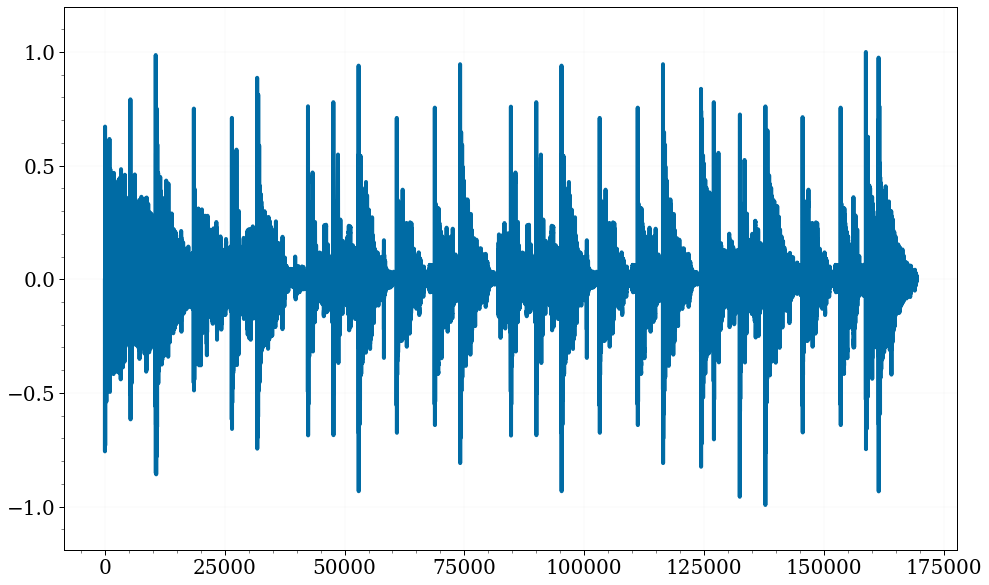

In [7]:
plt.plot(wav)

### SVD como um problema de otimização

Agora voltando para SVD. Observe como o espectrograma é uma matriz de valores complexas

In [8]:
S = librosa.stft(wav)
S[1, 0]

(21.010492-2.903927e-15j)

In [9]:
S.real

array([[-2.04294434e+01, -9.60280991e+00,  8.57357323e-01, ...,
         2.86548818e-03,  2.77445111e-02,  1.50528997e-01],
       [ 2.10104923e+01, -1.22868609e+00, -5.03100574e-01, ...,
        -2.04157755e-02,  7.20952218e-03, -6.23248741e-02],
       [-2.65991325e+01,  1.11167183e+01,  2.21814632e+00, ...,
         1.98108591e-02,  2.22539827e-02, -1.32204458e-01],
       ...,
       [-1.06431765e-03,  6.45676104e-04,  5.56440573e-05, ...,
         2.59905064e-05,  3.07723647e-04, -2.18525412e-03],
       [ 9.81305144e-04, -3.17966886e-04, -2.34028790e-04, ...,
        -1.96095876e-04, -1.19744625e-04, -1.15760497e-03],
       [-6.83862483e-04,  5.79404514e-05,  3.53292795e-04, ...,
         3.19004641e-04,  5.40562265e-04,  3.09617771e-03]], dtype=float32)

In [10]:
S.imag

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.9039271e-15,  1.0714315e+01, -2.4061909e-01, ...,
        -5.8182417e-03,  1.4468883e-02,  1.1686841e-01],
       [-4.6189223e-15,  3.4777143e+00, -4.1857952e-01, ...,
         3.1232927e-02, -3.4713306e-02, -9.1028683e-02],
       ...,
       [ 1.7803019e-16,  3.2414848e-04, -2.9644073e-04, ...,
        -1.3354661e-04, -3.1610118e-05,  2.0205786e-03],
       [ 5.1694760e-16, -6.9710822e-04,  3.7518269e-04, ...,
        -8.7013963e-05, -2.8488161e-05, -2.5324591e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

Como é comum, vamos trabalhar na norma do número complexo. Assim, fazemos uso de `np.abs` para pegar tal norma. Isto é, sendo $z$ o valor complexo, $z = a + i\cdot b$, então sua norma é $|z| = \sqrt{a^2 + b^2}$.

Vamos guardar também o ângulo. Teremos um uso para o mesmo no futuro.

In [11]:
X = np.abs(S)
A = np.angle(S)

In [12]:
def plot_spec(X, fig=None, ax=None, color=True):
    '''Aqui X tem que ser o absoluto'''

    if fig is None and ax is None:
        fig, ax = plt.subplots()

    X_db = librosa.amplitude_to_db(X, ref=np.max)
    img = librosa.display.specshow(X_db, x_axis='time', y_axis='log', ax=ax)
    if color:
        fig.colorbar(img, ax=ax, format="%+2.f dB");

Por fim, temos o nosso espectrograma de tempo curto!

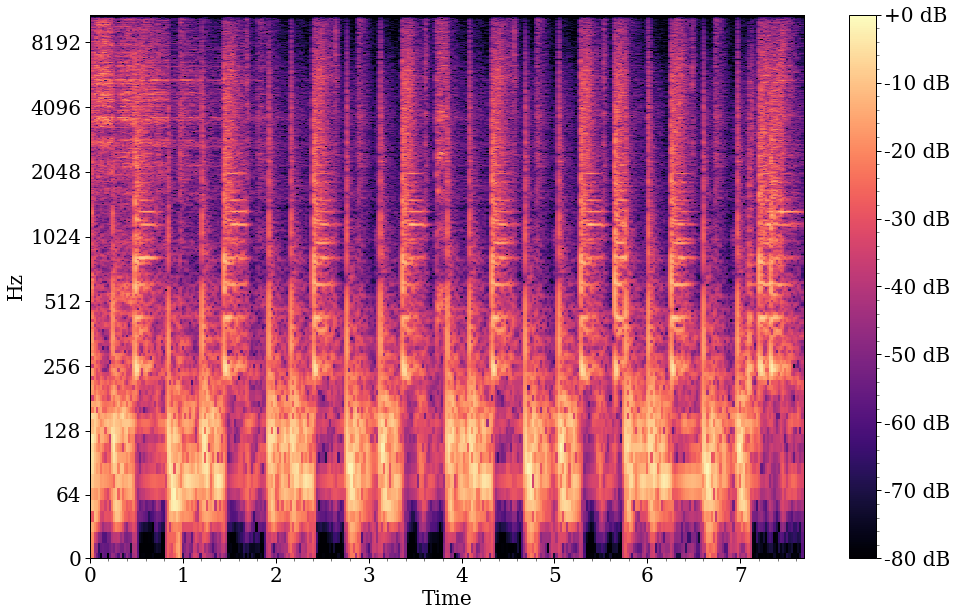

In [13]:
plot_spec(X)


Agora vamos tentar colar as duas coisas juntas. A bateria tem uma série de informação que se repete, abaixo tentei ressaltar algumas partes.

![](https://dcc.ufmg.br/~flaviovdf/mir/lab08/figs/fig3.png)

Parece que algums frequências aparecem mais em alguns tempos. Primeiro temos frequências baixa, depois alta, depois baixa. Tu, pa, tu, pa.... Além disso deve ter um ts, ts, ts constante por aí. O importante é. INFORMAÇÃO REDUNDANTE. Que ferramenta bacana aprendemos para achar tal informação?


## Otimizando SVD


Observe que podemos re-escrever nossa definição de SVD da seguinte forma:

$$ U_s V^{t} - X = \mathbf{0} $$ 

Onde, $\mathbf{0}$ é uma matriz do mesmo tamanho de X, porém composta apenas de zeros. Ora, se a diferença acima é a matriz de zeros, isto quer dizer que a norma dos dois lados (isto vai valer para qualquer norma) tem que ser zero! 

$$ || U_s V^{t} - X || =  || \mathbf{0} || $$ 

Você já deve estar pensando, ok, vou otimizar alguma coisa. Portando, vamos trabalhar com normas *ponto-a-ponto*:

$$ || U_s V^{t} - X ||_{p} =  0 $$

Onde a norma é definida como:

$$|| M \|_{p} = \left( \sum_{i=1}^n \sum_{j=1}^m |a_{i,j}|^p \right)^{1/p}$$

Vamos fazer uso da norma $p=2$ e elevar ao quadrado, tudo é mais fácil ao quadrado. E no fim do dia é um pouco por isso mesmo.

$$ || U_s V^{t} - X ||^2_{2} = \sum_{i=1}^n \sum_{j=1}^m ( (U_s V^{t})_{i,j} - X_{i,j})^2 = 0 $$

Uma soma de quadrados. Que lindo. Conhecemos os dados $X$, nosso espectrograma. Desconhecemos $U_s$ e $V$. Como achar? Deriva, otimiza, seja feliz, use JAX.

In [14]:
@jax.jit
def svd_loss(Us, Vh, X):
    X_model = Us @ Vh
    return jnp.mean((X - X_model) ** 2)

In [15]:
grad_fn = jax.grad(svd_loss, argnums=(0, 1))

Agora vamos testar!

In [16]:
k = 3
rows, cols = X.shape
Us = jnp.array(np.random.normal(size=(rows, k)))
Vh = jnp.array(np.random.normal(size=(k, cols)))

lr = 10
for i in range(5000):
    Us_prime, Vh_prime = grad_fn(Us, Vh, X)
    Us = Us - lr * Us_prime
    Vh = Vh - lr * Vh_prime
    if i % 100 == 0:
        print(i, svd_loss(Us, Vh, X))

0 12.726865
100 3.8700974
200 2.3550363
300 2.2916474
400 2.180054
500 2.096831
600 2.065479
700 2.0545874
800 2.0488753
900 2.0440662
1000 2.039045
1100 2.033571
1200 2.0277147
1300 2.0216947
1400 2.015791
1500 2.010273
1600 2.0053463
1700 2.001125
1800 1.9976343
1900 1.9948313
2000 1.9926332
2100 1.9909418
2200 1.9896585
2300 1.9886957
2400 1.987979
2500 1.987449
2600 1.9870589
2700 1.9867722
2800 1.9865626
2900 1.9864093
3000 1.9862975
3100 1.9862158
3200 1.9861566
3300 1.9861133
3400 1.9860817
3500 1.986059
3600 1.9860424
3700 1.9860302
3800 1.9860213
3900 1.9860148
4000 1.9860103
4100 1.986007
4200 1.9860044
4300 1.9860026
4400 1.986001
4500 1.9860003
4600 1.9859996
4700 1.985999
4800 1.9859986
4900 1.9859985


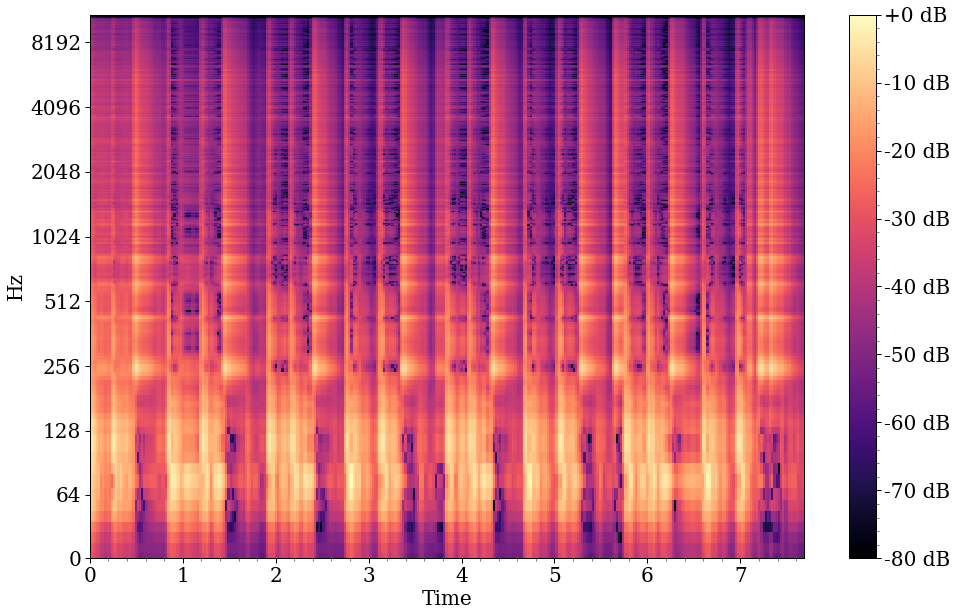

In [17]:
# Observe como funciona bem
plot_spec(Us @ Vh)

Abaixo tenho uma função que plota a parte recuperada por cada "produto externo". Ou seja, olho apenas para uma linha/coluna de Us e Vt.


In [18]:
def recover_from_one(Us, Vh, factor):
    right = Us[:, factor][:, np.newaxis]
    left = Vh[factor][np.newaxis]
    return right.dot(left)

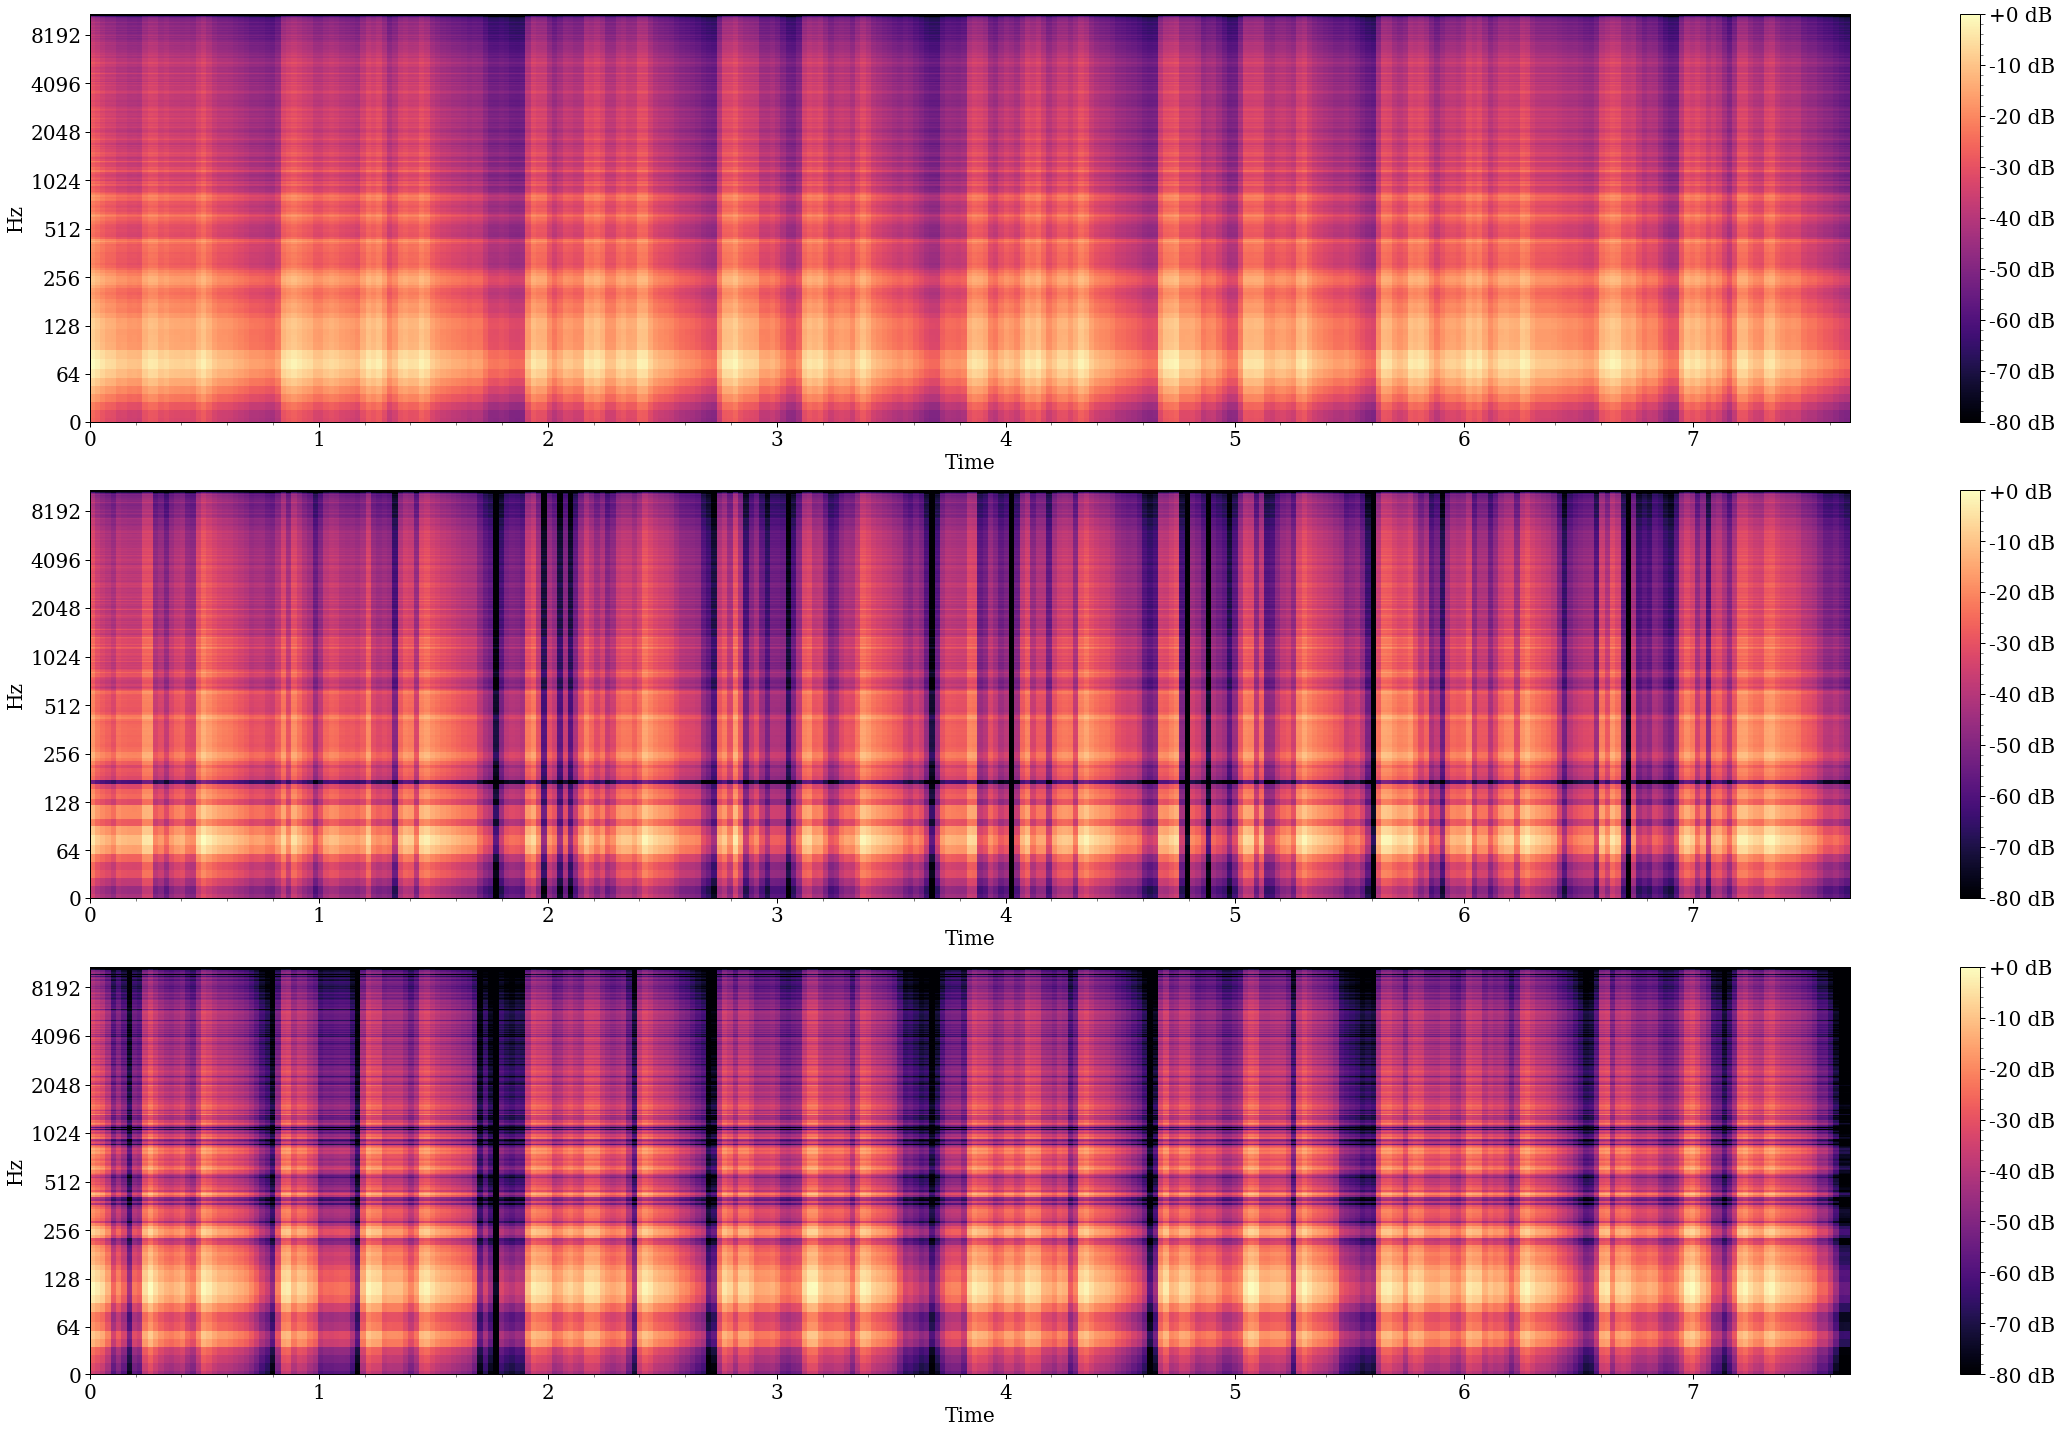

In [19]:
fig, axes = plt.subplots(k, 1, figsize=(32, 20))
for i in range(k):
    X_model = recover_from_one(Us, Vh, i)
    plot_spec(X_model, fig, axes[i])
fig.tight_layout()

Codificando tudo em uma função para uso futuro!

In [20]:
def svd(X, k, lr=10, max_iter=5000, verbose=True, Us=None, Vh=None):
    # Tirando as medidas da matriz X passada e não da global
    rows, cols = X.shape

    # Caso não passe k, as matrizes foram iniciadas por fora
    if k is None:
        assert(Us is not None or Vh is not None)
    
    # Caso Us não foi iniciada
    if Us is None:
        if k is None: # Vh foi iniciada ?
            assert(Vh is not None)
            k = Vh.shape[0]
        Us = jnp.array(np.random.normal(size=(rows, k)))

    # Aqui com certeza Us foi inicializada (na função ou fora)
    # Inice Vh caso não tenha sido por fora
    if Vh is None:
        k = Us.shape[1]
        Vh = jnp.array(np.random.normal(size=(k, cols))) 

    # Verifique os tamanhos
    assert(Us.shape[1] == Vh.shape[0])
    assert(Us.shape[1] <= X.shape[1])
    
    # Finalmente, SVD
    X = jnp.asarray(X)
    Us = jnp.asarray(Us)
    Vh = jnp.asarray(Vh)

    @jax.jit
    def svd_loss(Us, Vh, X):
        X_model = Us @ Vh
        return jnp.mean((X - X_model) ** 2)
    grad_fn = jax.grad(svd_loss, argnums=(0, 1))

    for i in range(max_iter):
        Us_prime, Vh_prime = grad_fn(Us, Vh, X)
        Us = Us - lr * Us_prime
        Vh = Vh - lr * Vh_prime
        if i % 100 == 0 and verbose:
            print(i, svd_loss(Us, Vh, X))
    return Us, Vh

0 12.636312
100 3.4436111
200 2.3650248
300 2.3201046
400 2.2071207
500 2.0805964
600 2.0225344
700 2.0029097
800 1.9953382
900 1.9917704
1000 1.9898193
1100 1.9886355
1200 1.9878635
1300 1.9873356
1400 1.986964
1500 1.9866982
1600 1.9865066
1700 1.9863675
1800 1.9862665
1900 1.9861934
2000 1.98614
2100 1.9861013
2200 1.9860729
2300 1.9860523
2400 1.9860375
2500 1.9860265
2600 1.9860188
2700 1.9860128
2800 1.9860088
2900 1.9860059
3000 1.9860036
3100 1.9860022
3200 1.9860009
3300 1.9860002
3400 1.9859996
3500 1.9859989
3600 1.9859986
3700 1.9859983
3800 1.9859982
3900 1.9859982
4000 1.9859979
4100 1.9859979
4200 1.9859979
4300 1.9859978
4400 1.9859978
4500 1.9859978
4600 1.9859978
4700 1.9859978
4800 1.9859978
4900 1.9859978


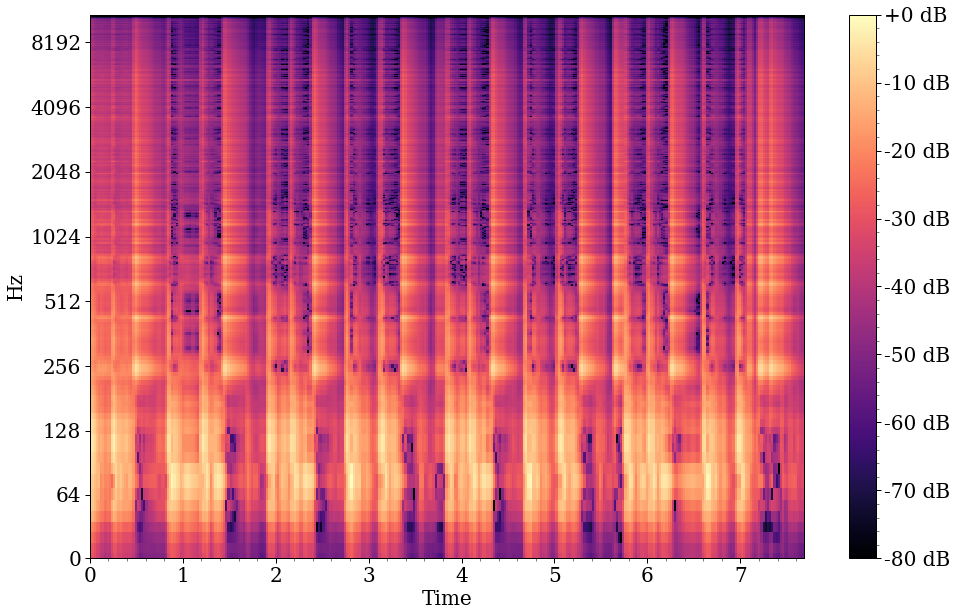

In [22]:
Us, Vh = svd(X, 3, verbose=True)
plot_spec(Us @ Vh)

## Voltando para a música original

Infelizmente nosso espectrograma tem fatores complexos. Nosso SVD não fez uso de tais fatores na sua otimização. Até que seria possível com JAX, mas preferi não fazer. Portanto, vou voltar o espectrograma para complexo usando o ângulo que guardamos antes. Escute cada trecho que é recuperado por cada fator do nosso SVD. *Fez sentido?*

In [23]:
X_model = recover_from_one(Us, Vh, 0)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [24]:
X_model = recover_from_one(Us, Vh, 1)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [25]:
X_model = recover_from_one(Us, Vh, 2)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

## Decomposição Não Negativa

Um dos problemas de SVD é que os valores recuperados podem ser negativos. Por exemplo, observe o primeiro fator abaixo:

/home/arthur/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


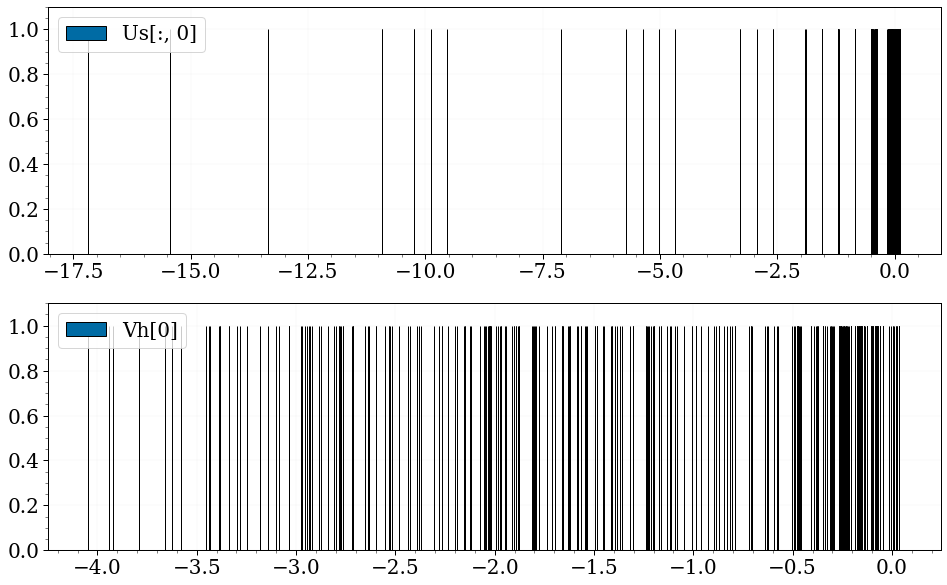

In [26]:
fig, axes = plt.subplots(2, 1)

axes[0].hist(Us[:, 0].ravel(), bins=50, edgecolor='k', label='Us[:, 0]')
axes[0].legend()

axes[1].hist(Vh[0].ravel(), bins=50, edgecolor='k', label='Vh[0]')
axes[1].legend()

Como temos números negativos, é complicado interpretar algum tipo de presença ou ausência de sinal. Isto vem do fato de que ao recuperar X com este fator teremos:

\begin{align}
    X &= \begin{bmatrix}
           c_{1, 1} \\
           c_{2, 1} \\
           \vdots \\
           c_{n, 1}
         \end{bmatrix}\begin{bmatrix}
           l_{1, 1}, 
           l_{1, 2}, 
           \cdots,
           l_{1, m}
         \end{bmatrix}
  \end{align}

Na expressão acima, podemos ter multiplicações de positivos com positivos, positivos com negativos (e vice-versa), ou negativos com negativos. Como X é toda positiva, seria melhor que os nossos fatores também fosse. Assim pelo menos podemos interpretar que quanto maior o valor, maior o sinal.

Existe uma "variação de SVD" (dizer que é variação é mentira, mas ok) onde podemos forçar que tudo seja positivo. A mesma está implementada abaixo.

In [27]:
def nmf(X, k, max_iter=5000, verbose=True, Us=None, Vh=None):
    # Tirando as medidas da matriz X passada e não da global
    rows, cols = X.shape

    # Caso não passe k, as matrizes foram iniciadas por fora
    if k is None:
        assert(Us is not None or Vh is not None)
    
    # Caso Us não foi iniciada
    if Us is None:
        if k is None: # Vh foi iniciada ?
            assert(Vh is not None)
            k = Vh.shape[0]
        Us = jnp.array(np.random.uniform(size=(rows, k)))

    # Aqui com certeza Us foi inicializada (na função ou fora)
    # Inice Vh caso não tenha sido por fora
    if Vh is None:
        k = Us.shape[1]
        Vh = jnp.array(np.random.uniform(size=(k, cols))) 

    # Verifique os tamanhos
    assert(Us.shape[1] == Vh.shape[0])
    assert(Us.shape[1] <= X.shape[1])

    # Finalmente, NMF
    X = jnp.asarray(X)
    Us = jnp.asarray(Us)
    Vh = jnp.asarray(Vh)

    for i in range(max_iter):
        Us = Us * ((X @ Vh.T) / (((Us @ Vh) @ Vh.T) + 0.0001))
        Vh = Vh * ((Us.T @ X) / (((Us.T @ Us) @ Vh) + 0.0001))
        if i % 100 == 0 and verbose:
            X_model = Us @ Vh
            print(i, jnp.mean((X - X_model) ** 2))
    return Us, Vh

Us, Vh = nmf(X, 3)

0 4.698392
100 1.9911516
200 1.9910303
300 1.9910161
400 1.9910114
500 1.9910104
600 1.9910103
700 1.9910103
800 1.9910101
900 1.9910101
1000 1.99101
1100 1.99101
1200 1.9910101
1300 1.99101
1400 1.99101
1500 1.99101
1600 1.99101
1700 1.99101
1800 1.99101
1900 1.99101
2000 1.99101
2100 1.99101
2200 1.99101
2300 1.99101
2400 1.99101
2500 1.99101
2600 1.99101
2700 1.99101
2800 1.99101
2900 1.99101
3000 1.99101
3100 1.99101
3200 1.99101
3300 1.99101
3400 1.99101
3500 1.99101
3600 1.99101
3700 1.99101
3800 1.99101
3900 1.99101
4000 1.99101
4100 1.99101
4200 1.99101
4300 1.99101
4400 1.99101
4500 1.99101
4600 1.99101
4700 1.99101
4800 1.99101
4900 1.9910101


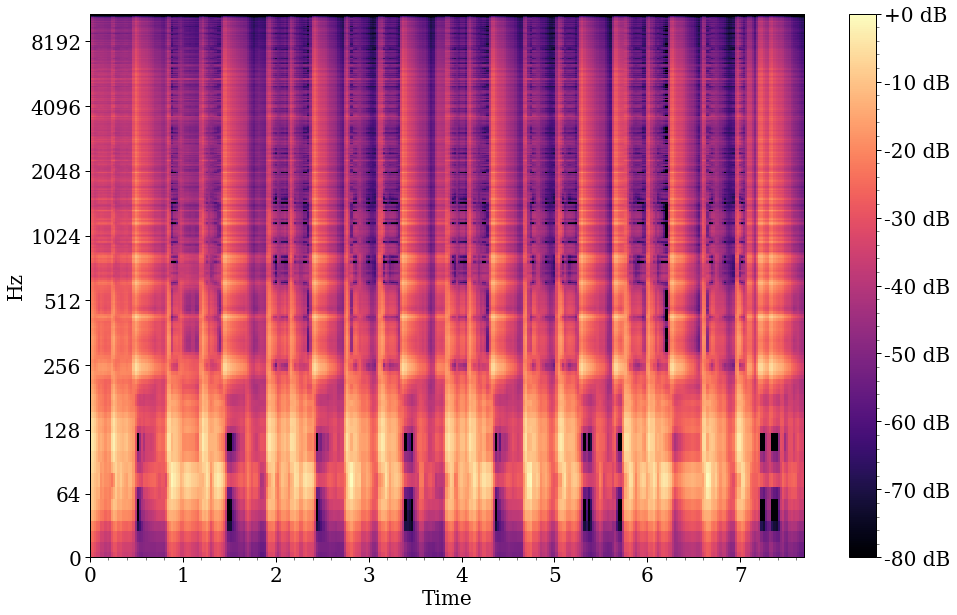

In [28]:
plot_spec(Us @ Vh)

Observe que agora tudo é não negativo

In [29]:
fig, axes = plt.subplots(2, 1)

for i in range(k):
    axes[0].hist(Us[:, i].ravel(), bins=50, edgecolor='k', label=f'Us[:, {i}]',
                 alpha=0.5)
    axes[1].hist(Vh[i].ravel(), bins=50, edgecolor='k', label=f'Vh[{i}]',
                 alpha=0.5)
axes[0].legend()
axes[1].legend()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f1868a0eb80> (for post_execute):


KeyboardInterrupt: 

Observe como os fatores mudam, ficam mais esparsos. Agora, podemos recuperar como antes. *Melhorou?*

In [ ]:
fig, axes = plt.subplots(k, 1, figsize=(32, 20))
for i in range(k):
    X_model = recover_from_one(Us, Vh, i)
    plot_spec(X_model, fig, axes[i])
fig.tight_layout()

In [ ]:
X_model = recover_from_one(Us, Vh, 0)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(Us, Vh, 1)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(Us, Vh, 2)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

## Sua Tarefa (Finalmente)

Usando a base anotada de toques de bateria do IDMT (já baixada, mas caso queira a original [venha aqui](https://www.idmt.fraunhofer.de/en/publications/datasets/drums.html)), sua tarefa será em decompor pequenas faixas de bateria. A base já foi baixada neste notebook. Os WAVs da mesma estão em ```audio/```.

In [ ]:
! ls audio

Para carregar todos use glob. Sua tarefa será fazer uso dos arquivos MIX, que já misturam todas os tambores. Observe que temos diferentes tipos de baterias. TechnoDrums, WaveDrums (eletrônicas) e RealDrums.

In [ ]:
import glob

files = glob.glob('audio/*MIX*.wav')
files

In [ ]:
wav, sr = librosa.load(files[1])
ipd.Audio(wav, rate=sr)

In [ ]:
! ls annotation_xml

Por motivos que eu nunca vou entender, os autores fizeram uso de XML para as anotações. Abaixo segue um exemplo de arquivo.

In [ ]:
! cat annotation_xml/RealDrum01_00#MIX.xml

Com BeautifulSoup você consegue extrair os tempos e nomes dos instrumentos.

In [ ]:
from bs4 import BeautifulSoup
with open('annotation_xml/RealDrum01_00#MIX.xml') as f:
    events = BeautifulSoup(f).findAll('event')
    times = []
    names = []
    for event in events:
        times.append(float(event.find('onsetsec').text))
        names.append(event.find('instrument').text)

**Sua Tarefa na Prática**

A figura abaixo mostra um exemplo do Librosa extraindo **curvas** de batidas com dois métodos diferentes. Em particular estamos comparando o [Onset Strength](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S1_OnsetDetection.html) e o [Predominant Local Pulse](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S3_PredominantLocalPulse.html).

![](https://librosa.org/doc/latest/_images/librosa-beat-plp-1_01.png)

Além do mais, com o nosso conhecimento de SVD e NMF sabemos decompor músicas. Vamos combinar os dois.


1. Você deve iniciar a matriz Us com frequências comuns em uma bateria. Caso queira, use os quatro quartis dos arquivos de cada tambor isolado (veja os WAVS).
1. Você deve iniciar a matriz Vt com os tempos de batidas.
1. Avalie se funcione, altera o número de fatores latentes extraídos por SVD/NMF.
1. Mensure a Precisão e Revocação!
1. Compare com inicializações aleatórias.


![](https://dcc.ufmg.br/~flaviovdf/mir/lab08/figs/fig4.png)

![](https://dcc.ufmg.br/~flaviovdf/mir/lab08/figs/fig5.png)

**Sua Solução**

# Solução

## Descoberta dos Arquivos de Áudio

O primeiro passo é obter a lista dos arquivos a serem usados. Temos uma lista com os áudios dos instrumentos misturados ("MIX") e uma para cada instrumento separado ("train"). Essas últimas serão usadas para inicializar as matrizes da decomposição.

In [ ]:
MIX_files = files
print(len(MIX_files), MIX_files[:3])

In [ ]:
KD_files = glob.glob('audio/*KD*train*.wav')
SD_files = glob.glob('audio/*SD*train*.wav')
HH_files = glob.glob('audio/*HH*train*.wav')

print(len(KD_files), KD_files[:3])
print(len(SD_files), SD_files[:3])
print(len(HH_files), HH_files[:3])

## STFT

Em seguida, temos que carregar cada um e extrair seu STFT. Para evitar computações repetidas, vamos guardar em dicionários os resultados.

In [ ]:
def stft(files):
    """
    Extrai o STFT de uma lista de arquivos WAV

    Parâmetros:
        files: lista de (caminhos para) arquivos WAV 
    Return:
        return_dict: dicionário com o STFT de cada arquivo, sendo que as chaves
                     são os elementos de 'files'
    """
    return_dict = {}
    total = len(files)
    i = 0
    for filename in files:
        # Carregar com librosa
        wav, sr = librosa.load(filename)

        # Extração dos fatores
        S = librosa.stft(wav)
        X = np.abs(S)
        A = np.angle(S)
        return_dict[filename] = (X,A)
        i += 1
        print(f'\r{(i*100/total):.1f}%', end='')
    print(f'\r{100}%')
    return return_dict

In [ ]:
# Nota: ~2min de execução (para a base toda)
MIX_stfts = stft(MIX_files[:10])
beats_stfts = {
    'KD': stft(KD_files[:10]),
    'SD': stft(SD_files[:10]),
    'HH': stft(HH_files[:10])
}

## Frequências para Inicialização

Para obter valores de frequência típicos a fim de inicializar as matrizes Us da decomposição, precisamos fazer, primeiramente, a decomposição em apenas uma dimensão para cada áudio de treino. 

In [ ]:
def run_decomposition(dict_stfts, method=svd):
    """
    Aplica um método de decomposição (SVD ou NMF) para um dicionário de STFTs.

    Parâmetros:
        dict_stfts: dicionário de instrumentos que mapeiam para arquivos, que
                    mapeiam para STFTs. Elas passarão pela decomposição.
        method: algoritmo de decomposição (nmf ou svd), padrão=svd
    Retorno:
        result_decomp: dicionário com a mesma organização de chaves, mas que 
                       guarda os pares (Us, Vh) resultados da decomposição de
                       cada STFT passado
    """
    result_decomp = {}

    # Loop pelo dicionário de STFTs
    total = len(dict_stfts)
    i = 0 
    for filename,(X,A) in dict_stfts.items():
        k = 1   # HH, KD ou SD (um apenas)
        rows, cols = X.shape
        Us, Vh = method(X, k, verbose=False)
        result_decomp[filename] = (Us,Vh)
        i += 1
        print(f'\r{(i*100/total):.1f}%', end='')
    print(f'\r{100}%')
    return result_decomp

In [ ]:
# Nota: demora! Só com 3 STFTs em cada levou ~3min no Colab
# Com 10STFTs em cada levou ~15min
beats_svd = {}
beats_nmf = {}

for beat, stft in beats_stfts.items():
    beats_svd[beat] = run_decomposition(stft,method=svd)
    beats_nmf[beat] = run_decomposition(stft,method=nmf)

Assim, podemos computar os quartis dos valores de frequência obtidos para os vários arquivos de áudio e seus respectivos STFTs.

In [ ]:
def quartiles(dict_decomp):
    """
    Computa os três quartis do vetor Us resultado da decomposição.

    Parâmetro:
        dict_decomp: dicionário de batidas que guarda dicionário de nomes de 
                     arquivo que mapeiam para resultados da decomposição do STFT
    Retornos:
        q25: 1º quartil (25%)
        q50: 2º quartil ou mediana (50%)
        q75: 3º quartil (75%)
    """
    # Stack horizontally all Us from dictionnary
    Us_list = []
    for filename, (Us, Vh) in dict_decomp.items():
        Us_list.append(Us)
    Us_list = tuple(Us_list)
    Us_quartile = jnp.hstack(Us_list)
    
    # Finds the quartiles
    q25 = np.quantile(Us_quartile,q=0.25,axis=1)
    q50 = np.quantile(Us_quartile,q=0.50,axis=1)
    q75 = np.quantile(Us_quartile,q=0.75,axis=1)
    return q25, q50, q75

In [ ]:
# Quartis dos SVD dos áudios de treino
# Produz dicionário do tipo
#    instrumento(beat) -> (q25, q50, q75)
# i.e., não há mais referência aos arquivos de áudio
quarts_svd = {}
for beat, svd_res in beats_svd.items():
    quarts_svd[beat] = quartiles(svd_res)

In [ ]:
# Quartis dos NMF dos áudios de treino
quarts_nmf = {}
for beat, nmf_res in beats_nmf.items():
    quarts_nmf[beat] = quartiles(nmf_res)

In [ ]:
quarts_nmf['HH'][0].shape

Para usarmos como inicialização da decomposição, precisamos empilhar os quartis. No momento, temos, para cada método de decomposição e para batida, um vetor $(1025,1)$. Temos que empilhar os três para montar uma matriz $(1025,3)$.

In [ ]:
def Us_stack(hh, sd, kd):
    """
    Empilha horizontalmente três vetores de frequência do treino. Assim, temos 
    uma matriz Us inicializada para a decomposição. A matriz de retorno tem esse
    formato:
        
     Us =    |  |  |
             HH SD KD
             |  |  |
    
    Parâmetros:
        hh: vetor do instrumento HH (prato)
        sd: vetor do instrumento SD (caixa)
        kd: vetor do instrumento KD (bumbo)
    """
    hh = hh.reshape(-1,1)
    sd = sd.reshape(-1,1)
    kd = kd.reshape(-1,1)
    return (jnp.hstack((hh, sd, kd)))

In [ ]:
# Us para warm start advindo do SVD
Us_svd = []
for i in range(3):
    stack = \
        Us_stack(quarts_svd['HH'][i], quarts_svd['SD'][i], quarts_svd['KD'][i])
    Us_svd.append(stack)

In [ ]:
# Us para warm start advindo do NMF
Us_nmf = []
for i in range(3):
    stack = \
        Us_stack(quarts_nmf['HH'][i], quarts_nmf['SD'][i], quarts_nmf['KD'][i])
    Us_nmf.append(stack)

In [ ]:
print(Us_svd[0].shape, Us_nmf[0].shape)

## Recuperação

Podemos agora comparar executar os métodos de decomposição para os áudios juntos e as diferentes formas de inicialização.

In [ ]:
def run_decomposition_mix(dict_stfts_mix, method=svd, Us=None, Vh=None):
    """
    Aplica um método de decomposição (SVD ou NMF) para um dicionário de STFTs.
    Pode receber matrizes inicializadas Us e Vh.

    Parâmetros:
        dict_stfts_mix: dicionário de arquivos que mapeiam para STFTs
        method: algoritmo de decomposição (nmf ou svd), padrão=svd
        Us: matriz Us que será usada no início do algoritmo (None usa matriz 
            aleatória). Padrão=None
        Vh: matriz Vh que será usada no início do algoritmo (None usa matriz 
            aleatória). Padrão=None
    Retorno:
        result_decomp: dicionário com a mesma organização de chaves, mas que 
                       guarda os pares (Us, Vh) resultados da decomposição de
                       cada STFT passado
    """
    result_decomp = {}

    # Loop pelo dicionário de STFTs
    total = len(dict_stfts_mix)
    i = 0 
    for filename,(X,A) in dict_stfts_mix.items():
        k = 3   # HH, KD ou SD (um apenas)
        rows, cols = X.shape
        Us_r, Vh_r = method(X, k, verbose=False, Us=Us, Vh=Vh)
        result_decomp[filename] = (Us_r,Vh_r)
        i += 1
        print(f'\r{(i*100/total):.1f}%', end='')
    print(f'\r{100}%')
    return result_decomp

In [ ]:
# Random
random_SVD = run_decomposition_mix(MIX_stfts, svd)
random_NMF = run_decomposition_mix(MIX_stfts, nmf)

In [ ]:
# Quartis SVD
quart_SVD = []
for i in range(3):
    quart_SVD.append(run_decomposition_mix(MIX_stfts, svd, Us=Us_svd[i]))

In [ ]:
# Quartis NMF
quart_NMF = []
for i in range(3):
    quart_NMF.append(run_decomposition_mix(MIX_stfts, nmf, Us=Us_nmf[i]))

Feitas as decomposições, é necessário recuperar o waveform do áudio novamente.

In [ ]:
def recover(Us, Vh, A, k=3, audio=False):
    """
    Recupera as formas de ondas a partir das matrizes Us e Vh advindas de 
    algoritmos de decomposição

    Parâmetros:
        Us: matriz Us
        Vh: matriz Vh
        A: matriz com complexos (resultado da STFT)
        k: nº colunas de Us = nº de linhas de Vh = nº de divisão da decomposição
        audio: mostrar player de áudio (padrão=False) 
    Retorno:
        wav_models: 'k' formas de onda recuperadas
    """
    wav_models = []
    for i in range(k):
        X_model = recover_from_one(Us, Vh, i)
        S_model = X_model * np.exp(1j * A)
        wav_model = librosa.istft(np.asarray(S_model))
        wav_models.append(wav_model)
        if (audio):
            ipd.display(ipd.Audio(wav_model, rate=sr))
    return wav_models

Usualmente, a ordem de índices é: o HH é o índice 0, o SD é índice 1 e o KD é o índice 2. Ou seja, na recuperação, o prato deve ser o primeiro, a caixa o segundo e o bumbo o terceiro. Na decomposição a partir do Random não temos essa garantia de ordem (assim, na hora de verificar com as anotações, temos que fazer todas as possibilidades e tomar a com melhor precisão).

In [ ]:
audio = 'audio/RealDrum01_04#MIX.wav'
U, V = quart_SVD[0][audio]
_X, _A = MIX_stfts[audio]
wavs = recover(U,V,_A,audio=True)

É possível notar que a ordem é exatamente a referida acima e que a separação é feita.

## Extração dos Picos

Para avaliação das mudanças propostas, temos que ter uma forma de comparar os resultados com as anotações constantes nos arquivos XML. Desse modo, usaremos o *scipy.signal.find_peaks* para tal tarefa.



In [ ]:
from scipy.signal import find_peaks

def extract_peak_times(waveform, sr=22050, distance=8000):
    """
    Encontra os tempos em que picos ocorrem numa forma de onda.

    Parâmetros:
        waveform: forma de onda
        sr: taxa de amostragem (sample rate)
        distance: parâmetro de escolha dos picos (vide scipy.signal.find_peaks)
    Retorno:
        peaks_sec: lista de tempos com os picos
    """
    # Finds indexes of peaks in waveform, considering a distance
    peaks_idx = find_peaks(waveform, distance=distance)[0]

    # Converts these indices to seconds 
    # Dividing by the sample rate yiels seconds
    peaks_sec = peaks_idx / sr
    return peaks_sec

O parâmetro *distance* como 8000 parece um bom valor para captar as batidas de cada instrumento e permitir uma comparação. Valores muito menores geram muitos falsos positivos e valores muito altos reduzem a quantidade de picos.

In [ ]:
fig, axs = plt.subplots(3,1)
fig.tight_layout() 
distances = [5000, 8000, 11000]

for i in range(3):
    wave = wavs[0]
    peaks_idx = find_peaks(wave, distance=distances[i])[0]
    axs[i].plot(peaks_idx, wave[peaks_idx], 'x')
    axs[i].plot(wave, color='orange')
    axs[i].set_title(f'distance={distances[i]}')

In [ ]:
def recover_with_peaks(Us, Vh, A):
    """
    Recupera as formas de onda das matrizes resultado da decomposição e já
    extrai os picos de cada uma delas.

    Parâmetros:
        Us: matriz Us da decomposição
        Vh: matriz Vh da decomposição
        A: matriz com complexos (resultado da STFT)
    Retorno:
        peaks: dicionário que guarda os tempos de pico para cada instrumento
    """
    # Waveform recovery
    waves = recover(Us,Vh, A)

    # Assuming HH=0, SD=1 and KD=2
    peaks = {}
    peaks['HH'] = extract_peak_times(waves[0])
    peaks['SD'] = extract_peak_times(waves[1])
    peaks['KD'] = extract_peak_times(waves[2])

    return peaks

In [ ]:
# Mesmo áudio do exemplo anterior
audio = 'audio/RealDrum01_04#MIX.wav'
U, V = quart_SVD[0][audio]
_X, _A = MIX_stfts[audio]

# Extraindo os picos
ret_peaks = recover_with_peaks(U,V,_A)
ret_peaks['HH'][:5]

## Comparação com as anotações

Os tempos corretos das batidas estão nos arquivos XML com mesmo nome dos áudios WAV.

In [ ]:
from collections import defaultdict
from bs4 import BeautifulSoup

def get_events(wav_name):
    """
    Produz um dicionário de instrumentos e suas respectivas timestamps de um
    arquivo XML com o mesmo nome do WAV passado. As timestamps retornadas estão
    em ordem.

    Parâmetro:
        filename: (caminho para) o arquivo WAV, será usado o XML correspondente
    Retorno:
        d: dicionário que mapeia os tipos de batida (instrumento) para um array
           ordenado de tempos
    """
    # Parse WAV path passed
    name_only = wav_name.split('/')[1]      # Split path from name
    xmlname = name_only.replace(".wav",".xml")

    # Extract times and names from XML file
    with open(f'annotation_xml/{xmlname}') as f:
        events = BeautifulSoup(f).findAll('event')
        times = []
        names = []
        for event in events:
            times.append(float(event.find('onsetsec').text))
            names.append(event.find('instrument').text)
    
    # Put them in a defaultdict
    d = defaultdict(list)
    for beat, time in list(zip(names,times)):
        d[beat].append(time)
    
    # Sorting the list in each key to speed up search later
    # (They are already sorted by construction of the XML file, 
    # but just to be sure)
    for beat in d.keys():
        d[beat] = np.array(sorted(d[beat]))
    return d

Com essa função conseguimos obter uma lista separada para tipo de batida da bateria presente nos áudios.

In [ ]:
peaks_anot = get_events(MIX_files[2])
print(peaks_anot['HH'][:3], peaks_anot['KD'][:3], peaks_anot['SD'][:3])

## Métricas

Precisamos de métricas para avaliar as comparações feitas. Como pedido no enunciado, devemos verificar a precisão e revocação, emparelhando os picos obtidos com os corretos, admitindo uma tolerância definida.

Antes, é necessária uma forma de fazer esse emparelhamento com tolerância. Vamos adaptar com o uso do *np.searchsorted*. Por isso, inclusive, que etapas anteriores ordenavam seus resultados, para facilitar essa busca agora.

In [ ]:
import math

def find_nearest(array,value):
    """
    Encontra o valor mais próximo num array ordenado. 
    Adaptado de: https://stackoverflow.com/a/26026189

    Parâmetros:
        array: vetor ORDENADO para ser buscado
        value: valor desejado
    Retorno:
        nearest: valor mais próximo do fornecido presente no array
    """
    idx = np.searchsorted(array, value, side="left")
    if (idx > 0 and (
            idx == len(array) or
            math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])
                    )
        ):
        return array[idx-1]
    else:
        return array[idx]

### Precisão e Revocação

De posse desse procedimento, podemos computar os *true positives*, *false positives* e *false negatives* dos resultados.

In [ ]:
def accuracy_metrics(peaks_res, peaks_anot, tol=0.5):
    """
    Computa true positives, false positives e false negatives, considerando
    uma tolerância definida.
    
    Parâmetros:
        peaks_res: dicionário de picos obtidos pelo algoritmo
        peaks_anot: dicionário de picos corretos (anotados)
        tol: tolerância em segundos (Padrão=0.5)

    Retornos:
        true_positive: qtd. de acertos (true positive)
        tp: lista de eventos corretamente reportados (true positive)
        false_positive: qtd. de erros (false positive)
        fp: lista de eventos erronamente reportados (false positive)
        false_negative: qtd. de eventos não-reportados (false negative)
        fn: lista de eventos não reportados (false negative)

    """
    # Finds how many of retrieved are correct (within a tolerance)
    true_positive = 0
    tp = []
    false_positive = 0
    fp = []
    for beat, beat_times in peaks_res.items():
        for time in beat_times:
            nearest = find_nearest(peaks_anot[beat], time)
            if (abs(nearest - time) <= tol):
                true_positive += 1
                tp.append((beat,time))
            else:
                false_positive += 1
                fp.append((beat,time))

    # Finds how many of correct were reported as negative
    # i.e., are absent in retrieved
    false_negative = 0
    fn = []
    for beat, beat_times in peaks_anot.items():
        for time in beat_times:
            nearest = find_nearest(peaks_res[beat], time)
            if (abs(nearest - time) <= tol):
                # True positive, already counted
                pass
            else:
                false_negative += 1
                fn.append((beat,time))
    return true_positive, tp, false_positive, fp, false_negative, fn

Com essas métricas, é possível precisão e revocação com suas fórmulas tradicionais.

$$
Prec = \frac{tp}{tp+fp} \\
Rev = \frac{tp}{tp+fn}
$$



Contudo, ainda temos que decidir como escolher a tolerância. Os áudios que temos têm cerca de 15 segundos, então é aceitável pensar que essa tolerância não pode ser da ordem desse valor. Além disso, os eventos ocorrem na escala de fração de segundo.

Vamos usar, como sugerido em aula, uma tolerância de $0.5s$.
```
# Hardcoded 0.5 ou média dos trem lá?
```

Naturalmente, quando discutimos precisão e revocação é comum discutirmos também a métrica F1 que sumariza as duas anteriores.

In [ ]:
def f1_score(precision, recall):
    """
    Computa a métrica F1 para sumarizar precisão e revocação numa única métrica

    Parâmetros:
        precision: precisão (entre 0 e 1)
        recall: revocação (entre 0 e 1)
    Retorno:
        f1: métrica F1
    """
    f1 = 2 * precision * recall
    f1 = f1 / (precision + recall)
    return f1

In [ ]:
def precision_recall_f1(peaks_res, peaks_anot, tol=0.5):
    """
    Computa precisão, revocação e métrica F1 de dois dicionários de picos

    Parâmetros:
        peaks_res: dicionário de picos obtidos pelo algoritmo
        peaks_anot: dicionário de picos corretos (anotados)
        tol: tolerância em segundos (Padrão=0.5)
    Retornos:
        precision: precisão (entre 0 e 1)
        recall: revocação (entre 0 e 1)
        f1: métrica F1
    """
    tp, _, fp, _, fn, _ = accuracy_metrics(ret_peaks, peaks_anot, tol=0.5)
    precision = (tp/(tp+fp))
    recall = (tp/(tp+fn))
    f1 = f1_score(precision, recall)
    return precision, recall, f1

In [ ]:
tp, _, fp, _, fn, _ = accuracy_metrics(ret_peaks, peaks_anot, tol=0.5)
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1 = f1_score(precision, recall)
print(tp, fp, fn, (tp/(tp+fp)), (tp/(tp+fn)), f1)

### RMSE

Como estamos trabalhando com um contexto contínuo, pode ser interessante também avaliar o erro quadrático médio (RMSE) entre os picos encontrados e os reais.

In [ ]:
def rmse_approx(true, pred):
    """
    Computa a RMSE entre dois vetores, comparando valores próximos entre si
    
    Parâmetros:
        true: vetor correto
        pred: vetor de previsões
    Retorno:
        rmse: RMSE entre os dois vetores
    """
    true = sorted(true)
    pred = sorted(pred)

    sum = 0
    for val_t in true:
        nearest = find_nearest(pred, val_t)
        diff = nearest - val_t
        sum += diff ** 2
    sum = sum / len(true)
    return np.sqrt(sum)

In [ ]:
def rmse_peaks(peaks_res, peaks_anot):
    """
    Computa a RMSE média entre dois dicionários com eventos para os mesmos três 
    instrumentos de bateria.

    Parâmetros:
        peaks_res: dicionário de picos obtidos pelo algoritmo
        peaks_anot: dicionário de picos corretos (anotados)
    Retorno:
        rmse: média de RMSE entre os picos dos três instrumentos
    """
    sum_errors = 0
    assert (set(peaks_res.keys()) == set(peaks_anot.keys()))
    for beat, beat_times in peaks_anot.items():
        sum_errors += rmse_approx(peaks_anot[beat], peaks_res[beat])
    return sum_errors / len(peaks_anot.keys())

In [ ]:
rmse_peaks(ret_peaks, peaks_anot)

## Exemplo Completo

In [ ]:
random_SVD['audio/RealDrum01_04#MIX.wav']

In [ ]:
def get_results(decomposition, A, name, 
                ret_peaks, peaks_anot, tol, 
                verbose=False):
    U,V = decomposition
    ret_peaks = recover_with_peaks(U,V,A)
    p,r,f1 = precision_recall_f1(ret_peaks, peaks_anot, tol=tol)
    rmse = rmse_peaks(ret_peaks, peaks_anot)
    print(f'{name:^25s}: {p:.3f} {r:.3f} {f1:.3f} {rmse:.3f}')

In [ ]:
tol = 0.5
for audio in MIX_files:
    print(f'{audio}:')
    X, A = MIX_stfts[audio]
    peaks_anot = get_events(audio)

    get_results(random_SVD[audio], A, 'Random SVD', ret_peaks, peaks_anot, tol, True)
    get_results(random_NMF[audio], A, 'Random NMF', ret_peaks, peaks_anot, tol, True)

    for i in range(3):
        get_results(quart_SVD[i][audio], A, f'Quartil {(i+1)*0.25} SVD', ret_peaks, peaks_anot, tol, True)
    for i in range(3):
        get_results(quart_NMF[i][audio], A, f'Quartil {(i+1)*0.25} NMF', ret_peaks, peaks_anot, tol, True)

    print("")


In [ ]:
quart_SVD[]

In [ ]:
# Mesmo áudio do exemplo anterior
audio = 'audio/RealDrum01_04#MIX.wav'
U, V = quart_SVD[0][audio]
_X, _A = MIX_stfts[audio]

# Extraindo os picos
ret_peaks = recover_with_peaks(U,V,_A)
ret_peaks['HH'][:5]

# OFF 2

### SVD

In [ ]:
def run_SVD_internal(X):
    # SVD
    k = 1   # HH, KD ou SD (um apenas)
    rows, cols = X.shape
    # Us = jnp.array(np.random.normal(size=(rows, k)))
    # Vh = jnp.array(np.random.normal(size=(k, cols)))
    # print(X.shape, Us.shape, Vh.shape)
    Us, Vh = svd(X, k, verbose=False)
    return Us, Vh

In [ ]:
def run_SVD(dict_stfts):
    """
    Applies SVD to a dictionary of STFTs. Returns another dict of pairs (Us, Vh)
    which are the result of SVD.
    """
    result_svds = {}

    # Loop pelo dicionário de STFTs
    total = len(dict_stfts)
    i = 0 
    for filename,(X,A) in dict_stfts.items():
        Us, Vh = run_SVD_internal(X)
        result_svds[filename] = (Us,Vh)
        i += 1
        print(f'\r{(i*100/total):.1f}%', end='')
    print(f'\r{100}%')
    return result_svds

In [ ]:
# Nota: demora! Só com 3 STFTs em cada levou ~3min
KD_svd = run_SVD(KD_stfts)
SD_svd = run_SVD(SD_stfts)
HH_svd = run_SVD(HH_stfts)

In [ ]:
# Not used
def OLD_quartiles(dict_decomp):
    """
    Extracts the three quartiles of Us from decomposition dictionaries
    """
    dict_q25 = {}
    dict_q50 = {}
    dict_q75 = {}

    for filename, (Us, Vh) in dict_decomp.items():
        dict_q25[filename] = np.quantile(Us,q=0.25,axis=0)
        dict_q50[filename] = np.quantile(Us,q=0.50,axis=0)
        dict_q75[filename] = np.quantile(Us,q=0.75,axis=0)
    return dict_q25, dict_q50, dict_q75

In [ ]:
# Us for warm start
Us_25 = Us_stack(HH_25, SD_25, KD_25)
Us_50 = Us_stack(HH_50, SD_50, KD_50)
Us_75 = Us_stack(HH_75, SD_75, KD_75)

In [ ]:
Us_25.shape

## Decomposição dos Mixes

In [ ]:
files[15]

In [ ]:
def audioname(path):
    """
    Extracts audio file name without parent folders
    """
    return path.split('/')[1]
audioname(files[15])

In [ ]:
# Rodar o SVD no mix pra ver se melhora
# Carregar com librosa
wav, sr = librosa.load(files[15])

# Extração dos fatores
S = librosa.stft(wav)
X = np.abs(S)
A = np.angle(S)

In [ ]:
k = 3   # HH, KD, SD
rows, cols = X.shape

In [ ]:
# Random
# SVD
Us, Vh = svd(X, 3, verbose=False)
# plot_spec(Us @ Vh)

In [ ]:
# Recover
X_model = recover_from_one(Us, Vh, 0)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.display(ipd.Audio(wav_model, rate=sr))

X_model = recover_from_one(Us, Vh, 1)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.display(ipd.Audio(wav_model, rate=sr))

X_model = recover_from_one(Us, Vh, 2)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.display(ipd.Audio(wav_model, rate=sr))

In [ ]:
# Q25
# SVD
Us, Vh = svd(X, 3, verbose=False, Us=Us_25)
# plot_spec(Us @ Vh)

In [ ]:
# Recover
def recover(Us, Vh, k=3, audio=False):
    """
    Recover the waveform from Us and Vh matrices from decomposition
    """
    wav_models = []
    for i in range(k):
        X_model = recover_from_one(Us, Vh, i)
        S_model = X_model * np.exp(1j * A)
        wav_model = librosa.istft(np.asarray(S_model))
        wav_models.append(wav_model)
        if (audio):
            ipd.display(ipd.Audio(wav_model, rate=sr))
    return wav_models

In [ ]:
recover(Us,Vh,audio=True);

In [ ]:
# Recover
X_model_0 = recover_from_one(Us, Vh, 0)
S_model_0 = X_model_0 * np.exp(1j * A)
wav_model_0 = librosa.istft(np.asarray(S_model_0))
ipd.display(ipd.Audio(wav_model_0, rate=sr))

X_model_1 = recover_from_one(Us, Vh, 1)
S_model_1 = X_model_1 * np.exp(1j * A)
wav_model_1 = librosa.istft(np.asarray(S_model_1))
ipd.display(ipd.Audio(wav_model_1, rate=sr))

X_model_2 = recover_from_one(Us, Vh, 2)
S_model_2 = X_model_2 * np.exp(1j * A)
wav_model_2 = librosa.istft(np.asarray(S_model_2))
ipd.display(ipd.Audio(wav_model_2, rate=sr))

## Extração dos Picos

In [ ]:
print(wav_model_0.shape, wav_model_1.shape, wav_model_2.shape)
print(S_model_0.shape, S_model_1.shape, S_model_2.shape)


In [ ]:
# Dividir qtd. amostras / sample rate nos devolve a duração do áudio
len(wav_model_0)/sr

In [ ]:
# temos picos, como extraí-los?
plt.plot(wav_model_0)
plt.plot(wav_model_1)
plt.plot(wav_model_2)

In [ ]:
# Dividir índice / sample rate nos devolve a tempo desse índice
(len(wav_model_0)*.9)/sr

In [ ]:
from scipy.signal import find_peaks
peaks_idx = find_peaks(wav_model_0, distance=8000)[0]
plt.plot(peaks_idx, wav_model_0[peaks_idx], "x")
plt.plot(wav_model_0)

In [ ]:
peaks_sec = peaks_idx / sr
peaks_sec

In [ ]:
from scipy.signal import find_peaks

def extract_peak_times(waveform, sr=22050, distance=8000):
    """
    Returns a list timestamps when peaks occur in a waveform, 
    """
    # Finds indexes of peaks in waveform, considering a distance
    peaks_idx = find_peaks(waveform, distance=distance)[0]

    # Converts these indices to seconds 
    # Dividing by the sample rate yiels seconds
    peaks_sec = peaks_idx / sr
    return peaks_sec

In [ ]:
def recover_peaks(Us, Vh):
    """
    Recover audio waveform from decomposed matrices and extract peaks from each
    instrument
    """
    # Waveform recovery
    waves = recover(Us,Vh)

    # Assuming HH=0, SD=1 and KD=2
    peaks = {}
    peaks['HH'] = extract_peak_times(waves[0])
    peaks['SD'] = extract_peak_times(waves[1])
    peaks['KD'] = extract_peak_times(waves[2])

    return peaks

In [ ]:
peaks = recover_peaks(Us, Vh)

In [ ]:
peaks

## Comparação com as anotações

In [ ]:
from collections import defaultdict
from bs4 import BeautifulSoup

def getEvents(filename):
    """
    Get a dictionary of beats and correspondent timestamps from the XML.
    The timestamps for each beat are ordered
    """
    # Extract times and names from XML file
    audiofile = audioname(files[15])
    xmlname = audiofile.replace(".wav",".xml")
    with open(f'annotation_xml/{xmlname}') as f:
        events = BeautifulSoup(f).findAll('event')
        times = []
        names = []
        for event in events:
            times.append(float(event.find('onsetsec').text))
            names.append(event.find('instrument').text)
    
    # Put them in a defaultdict
    d = defaultdict(list)
    for beat, time in list(zip(names,times)):
        d[beat].append(time)
    
    # Sorting the list in each key to speed up search later
    # (They are already sorted by construction of the XML file, 
    # but just to be sure)
    for beat in d.keys():
        d[beat] = np.array(sorted(d[beat]))
    return d

In [ ]:
peaks_anot = getEvents(files[15])
print(peaks_anot['HH'][:3], peaks_anot['KD'][:3], peaks_anot['SD'][:3])

#### Precisão e Revocação

In [ ]:
import math

def find_nearest(array,value):
    """
    Finds the nearest value to passed as parameter in an ORDERED array

    Source: https://stackoverflow.com/a/26026189
    """
    idx = np.searchsorted(array, value, side="left")
    if (idx > 0 and (
            idx == len(array) or
            math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])
                    )
        ):
        return array[idx-1]
    else:
        return array[idx]

In [ ]:
def accuracy_metrics(peaks_res, peaks_anot, tol=0.5):
    """
    Computes true positives, false positives and false negatives, within a 
    tolerance.

    """
    # Finds how many of retrieved are correct (within a tolerance)
    true_positive = 0
    tp = []
    false_positive = 0
    fp = []
    for beat, beat_times in peaks_res.items():
        for time in beat_times:
            nearest = find_nearest(peaks_anot[beat], time)
            if (abs(nearest - time) <= tol):
                true_positive += 1
                tp.append((beat,time))
            else:
                false_positive += 1
                fp.append((beat,time))

    # Finds how many of correct were reported as negative
    # i.e., are absent in retrieved
    false_negative = 0
    fn = []
    for beat, beat_times in peaks_anot.items():
        for time in beat_times:
            nearest = find_nearest(peaks_res[beat], time)
            if (abs(nearest - time) <= tol):
                # True positive, already counted
                pass
            else:
                false_negative += 1
                fn.append((beat,time))
    return true_positive, tp, false_positive, fp, false_negative, fn

In [ ]:
def f1_score(precision, recall):
    """
    Computes F1 score to summarize precision and recall into one metric
    """
    f1 = 2 * precision * recall
    f1 = f1 / (precision + recall)
    return f1

In [ ]:
def mean_interval(dict_of_vects):
    """
    Computes the mean difference two consecutive elements of a (sorted) vector, 
    considering the juxtaposition (append) of all vectors stored in a dictionary
    """
    total = 0
    intervals = []
    for key, vect in dict_of_vects.items():
        total += len(dict_of_vects[key])
        for elem in vect:
            intervals.append(elem)
    intervals = sorted(intervals)

    mean_intv = np.mean(np.diff(intervals))
    return mean_intv

In [ ]:
# Mean between event i and i+1 (considering sorted)
mean_intv = mean_interval(peaks_anot)
mean_intv

In [ ]:
tp, _, fp, _, fn, _ = accuracy_metrics(peaks, peaks_anot, tol=mean_intv)
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1 = f1_score(precision, recall)
print(tp, fp, fn, (tp/(tp+fp)), (tp/(tp+fn)), f1)

#### RMSE

In [ ]:
def rmse_approx(true, pred):
    """
    Computes the RMSE between two vectors, comparing each nearest value 
    """
    true = sorted(true)
    pred = sorted(pred)

    sum = 0
    for val_t in true:
        nearest = find_nearest(pred, val_t)
        diff = nearest - val_t
        sum += diff ** 2
    sum = sum / len(true)
    return np.sqrt(sum)

In [ ]:
def rmse(peaks_res, peaks_anot):
    sum_errors = 0
    assert (set(peaks_res.keys()) == set(peaks_anot.keys()))
    for beat, beat_times in peaks_anot.items():
        sum_errors += rmse_approx(peaks_anot[beat], peaks_res[beat])
    return sum_errors / len(peaks_anot.keys())

In [ ]:
rmse(peaks, peaks_anot)

# OFF

In [ ]:
def precision(peaks_res, peaks_anot, tol=0.5):
    """
    Computa a precisão da separação feita. Na prática, computa, dentre todos os 
    eventos reportados, quais realmente estão corretos, considerando uma 
    tolerância de tempo em segundos.
    """
    # Finds how many events were retrieved
    total_retrieved = 0
    for beat in peaks_res.keys():
        total_retrieved += len(peaks_res[beat])

    # Finds how many of retrieved are correct (within a tolerance)
    correct_retrieved = 0
    for beat, beat_times in peaks_res.items():
        for time in beat_times:
            nearest = find_nearest(peaks_anot[beat], time)
            if (abs(nearest - time) <= tol):
                correct_retrieved += 1

    return correct_retrieved / total_retrieved

In [ ]:
for tol in np.arange(0.2,2.0,0.2):
    print(f'{tol:.1f}: {precision(peaks, peaks_anot, tol=tol):.3f}')

Aumentar a tolerância aumenta a precisão (avá).

In [ ]:
def recall(peaks_res, peaks_anot, tol=0.5):
    """
    Computa a revocação da separação feita. Na prática, computa, dentre todos os 
    eventos existentes (anotados e corretos), quantos deles foram reportados, 
    considerando uma tolerância de tempo em segundos
    """
    # Finds how many events are annotated as correct, i.e., are relevant
    total_relevant = 0
    for beat in peaks_anot.keys():
        total_relevant += len(peaks_anot[beat])

    # Finds how many of retrieved are correct (within a tolerance)
    correct_retrieved = 0
    for beat, beat_times in peaks_res.items():
        for time in beat_times:
            nearest = find_nearest(peaks_anot[beat], time)
            if (abs(nearest - time) <= tol):
                correct_retrieved += 1

    return correct_retrieved / total_relevant

In [ ]:
for tol in np.arange(0.2,2.0,0.2):
    print(f'{tol:.1f}: {recall(peaks, peaks_anot, tol=tol):.3f}')

In [ ]:
plt.scatter(peaks)

In [ ]:
def f1_score(precision, recall):
    """
    Como temos precision e recall, convém computar a métrica f1 para sumarizar 
    as duas em uma única métrica.
    """
    pass

In [ ]:
"max(times)

In [ ]:
print(len(times), len(names))

Para saber qual som é qual: 

KD: bumbo (grave) \\
HH: prato (metálico, agudo) \\
SD: caixa (agudo)

Usando o stack de Us feito, temos:

     Us =    |  |  |
             HH SD KD
             |  |  |

Assim, o HH é o índice 0, o SD é índice 1 e o KD é o índice 2. Ou seja, na recuperação, o prato deve ser o primeiro, a caixa o segundo e o bumbo o terceiro. Na decomposição a partir do Random não temos essa garantia de ordem (assim, na hora de verificar com as anotações, temos que fazer todas as possibilidades e tomar a com melhor precisão)

In [ ]:
X, A = KD_stfts[KD_files[2]]
k = 1   # HH, KD ou SD (um apenas)
Us, Vh = run_SVD_internal(X)

In [ ]:
plot_spec(Us @ Vh)

In [ ]:
# Us tem as frequências
print(Us.shape)

# Vh tem os tempos
print(Vh.shape)

In [ ]:
# Carregar com librosa
wav, sr = librosa.load(files[1])

# Extração dos fatores
S = librosa.stft(wav)
X = np.abs(S)
A = np.angle(S)

In [ ]:
k = 3   # HH, KD, SD
rows, cols = X.shape
Us = jnp.array(np.random.normal(size=(rows, k)))
Vh = jnp.array(np.random.normal(size=(k, cols)))

In [ ]:
# NMF
Us, Vh = nmf(X, 3, verbose=False)
plot_spec(Us @ Vh)

In [ ]:
# NMF
Us, Vh = nmf(X, 3)
plot_spec(Us @ Vh)

# SVD
Us, Vh = svd(X, 3, verbose=True)
plot_spec(Us @ Vh)

# Recover
X_model = recover_from_one(Us, Vh, 1)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)